In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
import jax
import jax.numpy as jnp
import multiprocessing as mp

%matplotlib inline
%load_ext autoreload
%autoreload 2

# jax.config.update('jax_platform_name', 'cpu')

In [2]:
def activation_probs(x, w):
    # w : site weights, n x d
    # x : current levels, c x d
    site_activations = jnp.dot(w, jnp.transpose(x)) # dimensions: n x c
    p_sites = jax.nn.sigmoid(site_activations) # dimensions : n x c
    p = 1 - jnp.prod(1 - p_sites, 0)  # dimensions: c

    return p

In [3]:
# Path definitions
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = None
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

dataset = "2020-10-06-7"
estim = "data003/data003-all"
estim_1elec = "data001"
wnoise = "kilosort_data000/data000"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)

p = 2
cell = 259

X_expt_orig = mutils.get_stim_amps_newlv(electrical_path, p)
w_true = jnp.array([[-5.98518703, -5.73843676, -1.36037982, -0.05980741],
       [-5.98518703, -2.28047189, -2.93318102, -4.31001908],
       [-5.98518703,  5.39557745,  1.95279497,  1.8031558 ],
       [-5.98518703, -0.25671708,  2.89097144,  3.80746902]])

X = jnp.array(sm.add_constant(X_expt_orig, has_constant='add'))
p_true = activation_probs(X, w_true) # prob with each current level

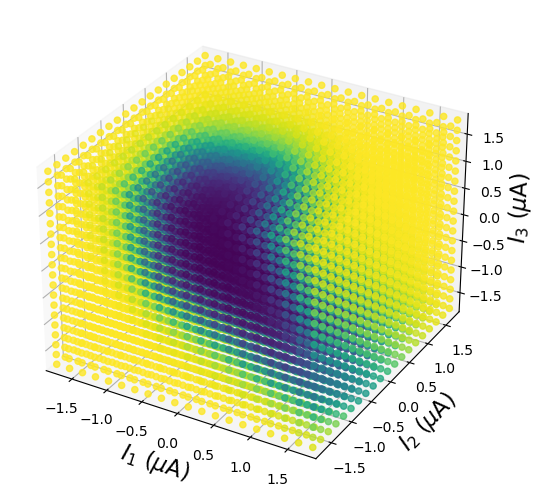

In [4]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=p_true, s=20, alpha=0.8, vmin=0, vmax=1)

In [5]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    return p_empirical

In [6]:
def neg_log_likelihood(w, x, y, trials, l2_reg=0):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # trials: number of trials at each current level, c
    # l2_reg: l2 regularization penalty
    # w = w.reshape(-1, x.shape[-1])  # dimensions: n x d
    
    p_model = activation_probs(x, w) # dimensions: c
    p_model = jnp.clip(p_model, a_min=1e-5, a_max=1-1e-5)

    trials = trials.astype(int)
    
    nll = -jnp.sum(trials * y * jnp.log(p_model) + trials * (1 - y) * jnp.log(1 - p_model))

    penalty = l2_reg/2 * jnp.linalg.norm(w)**2

    return nll + penalty

In [7]:
def optimize_w(x, w, y, trials, l2_reg=0, zero_prob=0.01, step_size=0.0001, n_steps=100, wtol=1e-4):

    m = len(w)
    z = 1 - (1 - zero_prob)**(1/m)

    @jax.jit
    def update(x, w, y, trials, l2_reg):
        grads = jax.grad(neg_log_likelihood)(w, x, y, trials, l2_reg=l2_reg)
        return grads

    losses = []
    prev_w = w
    for step in range(n_steps):
        grad = update(x, w, y, trials, l2_reg)
        w = w - step_size * grad
        losses += [neg_log_likelihood(w, x, y, trials, l2_reg=l2_reg)]
        w = w.at[:, 0].set(jnp.minimum(w[:, 0], np.log(z/(1-z))))

        print(step, jnp.linalg.norm(w - prev_w) / len(w.ravel()), jnp.linalg.norm(grad) / len(w.ravel()))
        if jnp.linalg.norm(w - prev_w) / len(w.ravel()) <= wtol:
            break
        prev_w = w
        
    return losses, w

In [8]:
def fisher_info(x, w, y, t):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # t: number of trials for each current level, c
    
    p_model = jnp.clip(activation_probs(x, w), a_min=1e-5, a_max=1-1e-5) # c
    I_p = jnp.diag(t / (p_model * (1 - p_model)))   # c x c
    J = jax.jacfwd(activation_probs, argnums=1)(x, w).reshape((len(x), w.shape[0]*w.shape[1]))
    I_w = jnp.dot(jnp.dot(J.T, I_p), J) / len(x)
    
    loss = jnp.trace(J @ (jnp.linalg.inv(I_w) @ J.T))
    # sign, logdet = jnp.linalg.slogdet(I_w)
    # loss = -sign * logdet
    return loss

In [9]:
def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - s) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

In [10]:
def optimize_fisher(x, w, y, t_prev, t, reg=0, T_budget=1000, step_size=0.001, n_steps=100, step_cnt_decrement=5, reltol=5e-10):

    @jax.jit
    def update(x, w, y, t_prev, t):
        fisher_lambda = lambda t, x, w, y, t_prev: fisher_info(x, w, y, t_prev + jnp.absolute(t)) + reg * jnp.sum(jnp.absolute(t))
        grads = jax.grad(fisher_lambda)(t, x, w, y, t_prev)

        return grads
    
    losses = []
    last_t = t
    for step in range(n_steps):
        grad = update(x, w, y, t_prev, t)
        t = t - step_size * grad
    
        losses += [[fisher_info(x, w, y, t_prev + jnp.absolute(t)), 
                    jnp.sum(jnp.absolute(t)),
                    fisher_info(x, w, y, t_prev + jnp.absolute(t)) + reg * jnp.sum(jnp.absolute(t))]]

        curr_loss = fisher_info(x, w, y, t_prev + jnp.absolute(t)) + reg * jnp.sum(jnp.absolute(t))
        last_loss = fisher_info(x, w, y, t_prev + jnp.absolute(last_t)) + reg * jnp.sum(jnp.absolute(last_t))
        rel_decrease = jnp.absolute(curr_loss - last_loss) / last_loss
        print(step, jnp.absolute(curr_loss - last_loss) / last_loss, jnp.linalg.norm(grad) / len(t))
        if rel_decrease <= reltol:
            break

        last_t = t
        if step % step_cnt_decrement == 0:
            step_size = step_size * 0.99
        
    # return np.array(losses), jnp.round(jnp.array(euclidean_proj_simplex(np.array(jnp.absolute(t)), s=T_budget)), 0)
    return np.array(losses), t


In [11]:
def get_performance_AL(X, w_meas, p_true):
    probs_pred = activation_probs(X, w_meas)
    RMSE = jnp.sqrt(jnp.sum((probs_pred - p_true)**2) / len(X))

    return RMSE

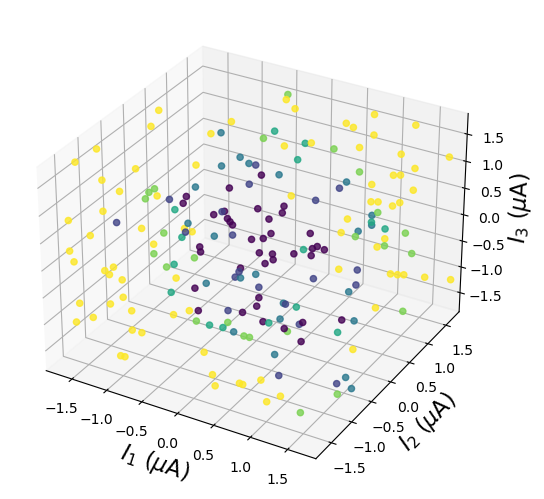

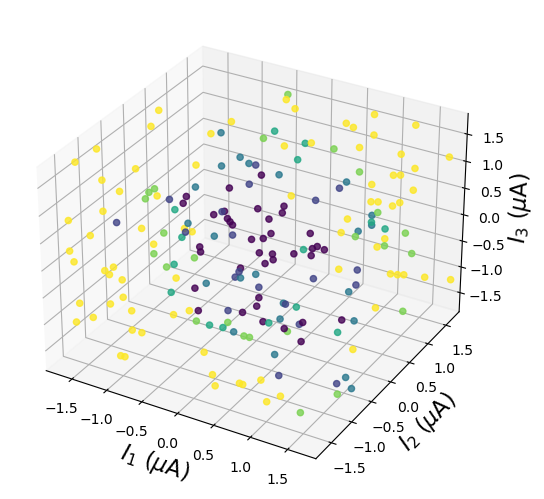

0 0.74371225 24.15889
1 0.023073176 29.669594
2 0.024129067 30.473072
3 0.02473075 30.875267
4 0.024877254 30.845076
5 0.024547078 30.336254
6 0.023738734 29.329403
7 0.022537857 27.903202
8 0.021108339 26.226473
9 0.019608606 24.468529
10 0.018141884 22.743109
11 0.016760793 21.110298
12 0.015485539 19.594704
13 0.014318462 18.200758
14 0.013253622 16.9232
15 0.012282476 15.7534
16 0.011396591 14.682426
17 0.01058844 13.702107
18 0.009851475 12.805122
19 0.009179755 11.984768
20 0.008567794 11.234749
21 0.008010425 10.549074
22 0.007502689 9.922025
23 0.0070398785 9.348181
24 0.0066176746 8.82249
25 0.006232027 8.340263
26 0.005879225 7.8972263
27 0.005555966 7.4895086
28 0.005259253 7.1136208
29 0.004986407 6.7664447
30 0.0047350265 6.445194
31 0.0045030164 6.1473894
32 0.0042884555 5.870825
33 0.0040897266 5.6135387
34 0.0039053168 5.3737774
35 0.003733888 5.149982
36 0.003574282 4.9407587
37 0.0034254368 4.7448616
38 0.0032864264 4.561173
39 0.0031563842 4.3886847
40 0.0030345856 4

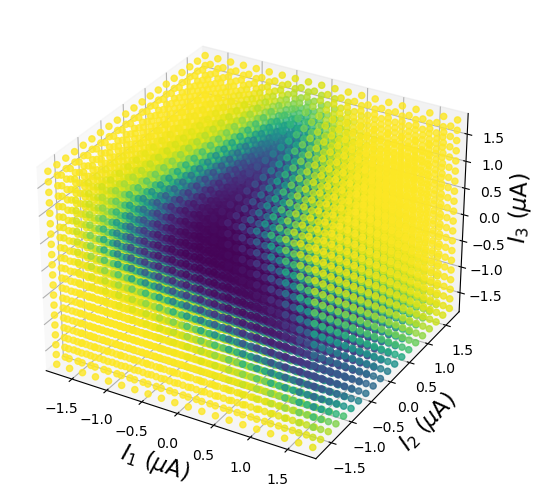

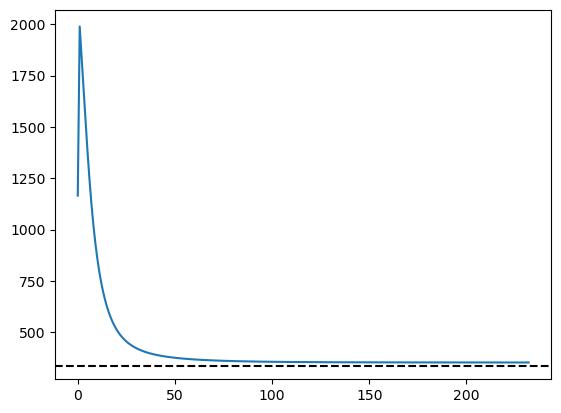

0 0.74371225 24.15889
1 0.023073176 29.669594
2 0.024129067 30.473072
3 0.02473075 30.875267
4 0.024877254 30.845076
5 0.024547078 30.336254
6 0.023738734 29.329403
7 0.022537857 27.903202
8 0.021108339 26.226473
9 0.019608606 24.468529
10 0.018141884 22.743109
11 0.016760793 21.110298
12 0.015485539 19.594704
13 0.014318462 18.200758
14 0.013253622 16.9232
15 0.012282476 15.7534
16 0.011396591 14.682426
17 0.01058844 13.702107
18 0.009851475 12.805122
19 0.009179755 11.984768
20 0.008567794 11.234749
21 0.008010425 10.549074
22 0.007502689 9.922025
23 0.0070398785 9.348181
24 0.0066176746 8.82249
25 0.006232027 8.340263
26 0.005879225 7.8972263
27 0.005555966 7.4895086
28 0.005259253 7.1136208
29 0.004986407 6.7664447
30 0.0047350265 6.445194
31 0.0045030164 6.1473894
32 0.0042884555 5.870825
33 0.0040897266 5.6135387
34 0.0039053168 5.3737774
35 0.003733888 5.149982
36 0.003574282 4.9407587
37 0.0034254368 4.7448616
38 0.0032864264 4.561173
39 0.0031563842 4.3886847
40 0.0030345856 4

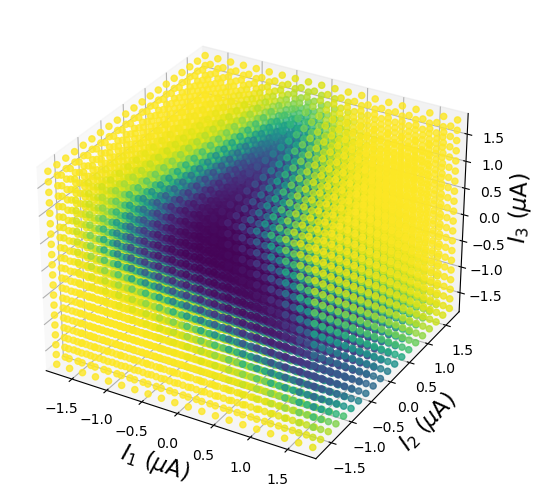

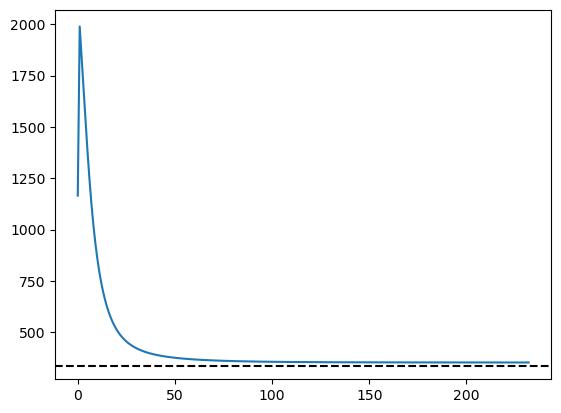

0.10517134 0.10517134
0 0.018812431 0.041050587
1 0.018322788 0.040300418
2 0.01810226 0.039674204
3 0.017920567 0.03910806
4 0.01775859 0.038576428
5 0.017606113 0.038065795
6 0.017282877 0.03756811
7 0.017135607 0.037083287
8 0.01698393 0.036602616
9 0.016826758 0.03612317
10 0.016660042 0.03564259
11 0.01631843 0.03515874
12 0.016132576 0.034674473
13 0.01593202 0.034183193
14 0.015715236 0.033683065
15 0.015482867 0.033172693
16 0.015078731 0.03265098
17 0.014813575 0.03212249
18 0.01452837 0.031581704
19 0.014227027 0.031028958
20 0.012810296 0.030465407
21 0.007924038 0.02989537
22 0.008454286 0.02936045
23 0.0047956877 0.028855015
24 0.0060496526 0.028400132
25 0.0029984098 0.027985416
26 0.004746187 0.027618663
27 0.0017998918 0.02728908
28 0.003968943 0.027005136
29 0.0011926483 0.026739841
30 0.003458332 0.026512522
31 0.0008174242 0.026299411
32 0.0030184386 0.026120232
33 0.0005254633 0.025952816
34 0.0027720816 0.025807107
35 0.0003068583 0.02566955
36 0.0026540612 0.02554

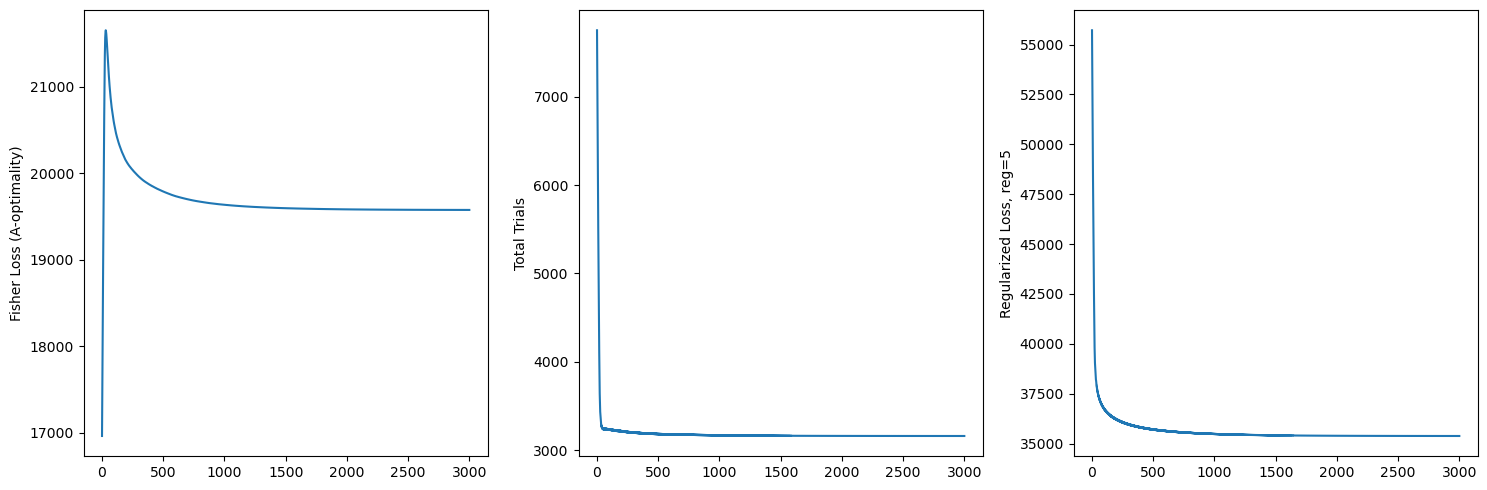

3141.0


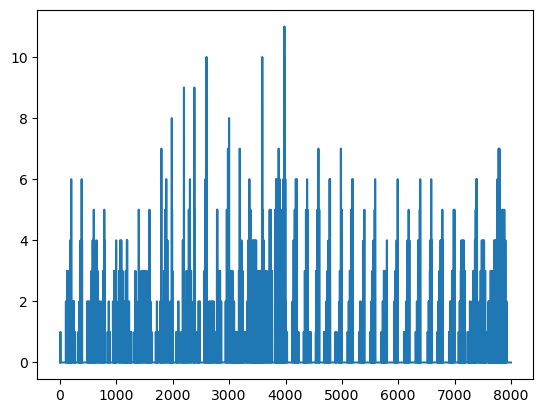

4141.0


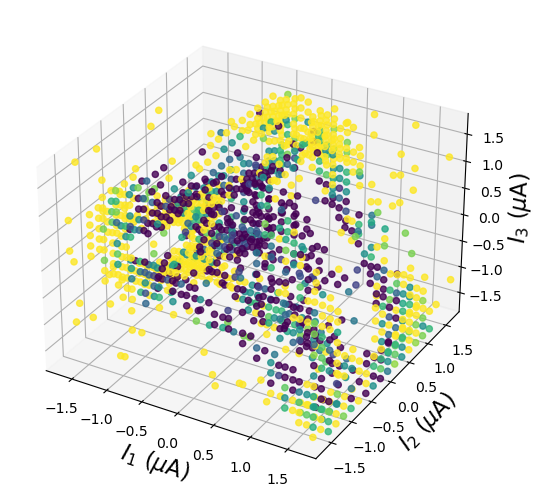

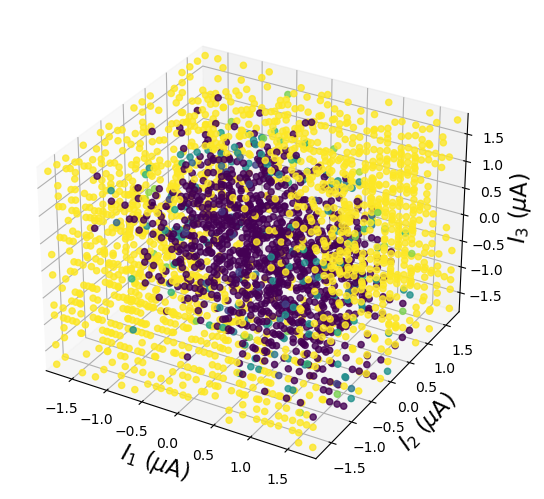

0 0.012563646 15.407531
1 0.008067034 10.837903
2 0.005880406 8.375087
3 0.004602403 6.786865
4 0.0037313553 5.642079
5 0.0030867283 4.773036
6 0.0025914656 4.097448
7 0.0022042266 3.565413
8 0.0018983892 3.1425683
9 0.0016549693 2.803752
10 0.0014597821 2.5300257
11 0.0013020025 2.3070009
12 0.0011733215 2.1236913
13 0.0010673624 1.9717011
14 0.000979213 1.8445929
15 0.00090508413 1.7374178
16 0.00084210385 1.646369
17 0.0007880311 1.568482
18 0.00074116694 1.5014373
19 0.0007001792 1.4434129
20 0.0006640592 1.3929437
21 0.0006319485 1.348855
22 0.0006032486 1.3101885
23 0.00057742826 1.2761705
24 0.00055408786 1.2461449
25 0.0005328756 1.219566
26 0.000513531 1.1959764
27 0.0004958071 1.1749896
28 0.00047951392 1.1562746
29 0.00046449905 1.1395539
30 0.00045062185 1.1245818
31 0.00043775042 1.111145
32 0.00042580438 1.0990677
33 0.00041467685 1.0881903
34 0.0004043051 1.0783721
35 0.00039460085 1.0695016
36 0.00038553542 1.0614722
37 0.00037702938 1.0541902
38 0.00036905997 1.0475776

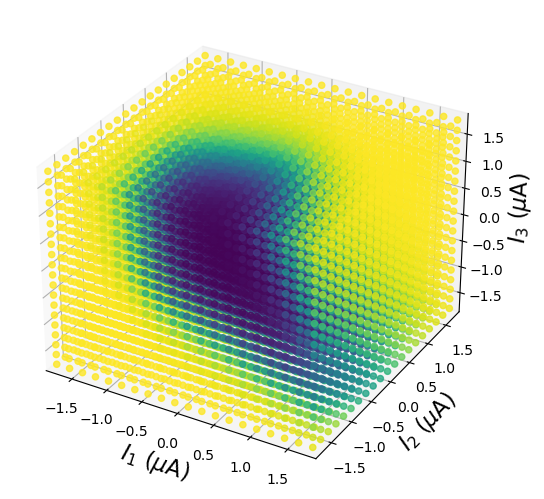

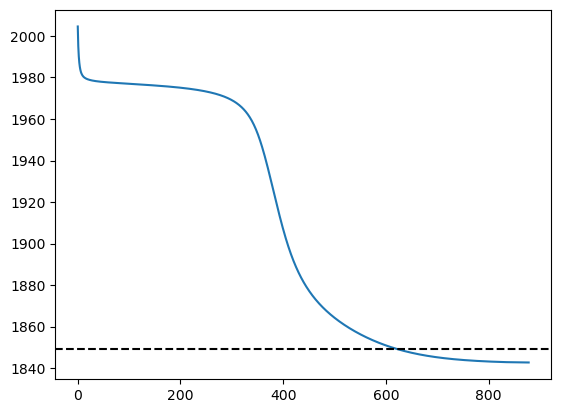

0 0.00368079 4.4935594
1 0.0031940097 4.004583
2 0.0028034206 3.6199212
3 0.002488107 3.3161848
4 0.0022315881 3.0747917
5 0.002020905 2.8811767
6 0.0018460104 2.7240791
7 0.0016990358 2.594897
8 0.0015740138 2.4871378
9 0.001466315 2.3959367
10 0.0013724137 2.3176696
11 0.0012896529 2.24963
12 0.0012159613 2.1898024
13 0.0011497847 2.136672
14 0.0010898896 2.0890818
15 0.0010353533 2.0461593
16 0.0009854325 2.007215
17 0.00093952497 1.9717118
18 0.0008971699 1.9392173
19 0.00085798034 1.9093748
20 0.0008216075 1.8818959
21 0.0007878214 1.856536
22 0.0007563584 1.8330815
23 0.00072702346 1.8113533
24 0.0006996492 1.791191
25 0.00067408074 1.7724557
26 0.0006501724 1.7550272
27 0.00062780676 1.7387897
28 0.0006068823 1.7236487
29 0.0005872729 1.7095138
30 0.00056887756 1.6963028
31 0.0005516477 1.6839396
32 0.00053546357 1.6723593
33 0.0005202663 1.6615014
34 0.00050600036 1.6513108
35 0.0004925701 1.6417366
36 0.00047993305 1.6327333
37 0.00046805447 1.624257
38 0.00045684457 1.6162665

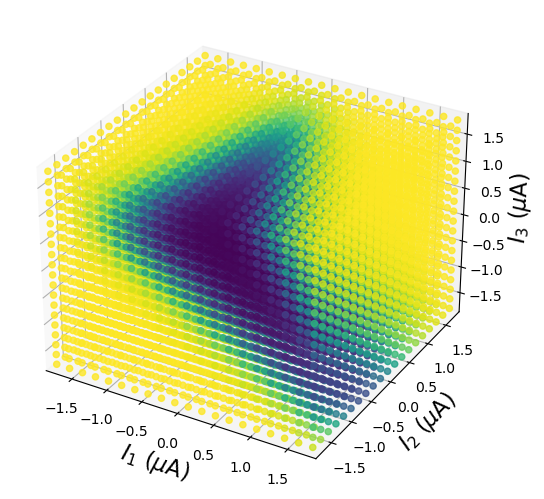

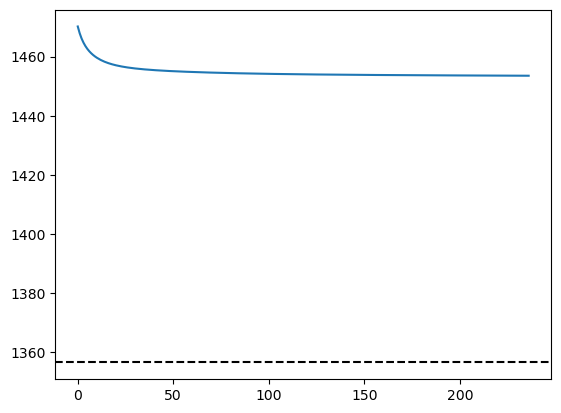

0.022420475 0.09708376
0 0.011920522 0.025587078
1 0.011811261 0.025445966
2 0.011819363 0.025304288
3 0.011825144 0.025160683
4 0.011827105 0.025015166
5 0.011828507 0.024867676
6 0.011706962 0.024718372
7 0.011702734 0.024568625
8 0.011694568 0.024417097
9 0.01168441 0.024263727
10 0.011670874 0.024108564
11 0.0115383165 0.023951624
12 0.011520442 0.023794534
13 0.0114984205 0.02363578
14 0.011474986 0.023475334
15 0.011446919 0.023313308
16 0.011303491 0.023149636
17 0.011270846 0.022986103
18 0.011236155 0.022821056
19 0.011197566 0.022654597
20 0.01115579 0.022486717
21 0.011002582 0.02231745
22 0.010955771 0.022148699
23 0.010907277 0.021978673
24 0.0108562745 0.02180753
25 0.010801666 0.021635378
26 0.0106385825 0.021462196
27 0.010579917 0.021289956
28 0.01052013 0.021116909
29 0.010456139 0.020943265
30 0.010392062 0.020769011
31 0.01022162 0.020594433
32 0.0101544075 0.020421352
33 0.010084192 0.02024822
34 0.00924312 0.020075114
35 0.0068687955 0.019902444
36 0.0071362746 0.

KeyboardInterrupt: 

In [12]:
%matplotlib inline
# Initialization
regs = [5, 3, 2, 1, 0.5, 0.1]
num_restarts = 1
init_size = 200
budget = 500
init_trials = 5

performance_stack = []
performance_stack_random = []

for m in range(num_restarts):
    # Initialize amplitudes
    init_inds = np.random.choice(len(X), replace=False, size=init_size)

    # Initialize trials
    T_prev = jnp.zeros(len(X_expt_orig))
    T_prev = T_prev.at[init_inds].set(init_trials)
    T_prev_random = jnp.copy(T_prev)

    p_empirical = jnp.array(sample_spikes(p_true, T_prev))
    p_empirical_random = jnp.copy(p_empirical)

    # Initialize weights
    w_init = jnp.array(np.random.normal(size=w_true.shape))
    w_init_random = jnp.copy(w_init)

    performances = []
    performances_random = []
    num_samples = []

    cnt = 0
    num_iters = 5

    while True:
        reg = regs[cnt]
        num_samples.append(np.sum(np.absolute(np.array(T_prev)).astype(int)))
        sampled_inds = np.where(np.absolute(np.array(T_prev)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
                    X_expt_orig[sampled_inds, 1],
                    X_expt_orig[sampled_inds, 2], marker='o', c=p_empirical[sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        sampled_inds_random = np.where(np.absolute(np.array(T_prev_random)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
                    X_expt_orig[sampled_inds_random , 1],
                    X_expt_orig[sampled_inds_random , 2], marker='o', c=p_empirical_random[sampled_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()
        
        # Optimize w
        losses, w_final = optimize_w(X, w_init, p_empirical, T_prev, l2_reg=0.01, step_size=0.001, n_steps=3500)
        p_pred = activation_probs(X, w_final)
        performance = get_performance_AL(X, w_final, p_true)
        performances.append(performance)

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[:, 0], 
                    X_expt_orig[:, 1],
                    X_expt_orig[:, 2], marker='o', c=p_pred, s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        plt.figure()
        plt.plot(losses)
        plt.axhline(neg_log_likelihood(w_true, X, p_empirical, T_prev), linestyle='--', c='k')
        plt.show()

        losses, w_final_random = optimize_w(X, w_init_random, p_empirical_random, T_prev_random, l2_reg=0.01, step_size=0.001, n_steps=3500)
        p_pred_random = activation_probs(X, w_final_random)
        performance_random = get_performance_AL(X, w_final_random, p_true)
        performances_random.append(performance_random)

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[:, 0], 
                    X_expt_orig[:, 1],
                    X_expt_orig[:, 2], marker='o', c=p_pred_random, s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        plt.figure()
        plt.plot(losses)
        plt.axhline(neg_log_likelihood(w_true, X, p_empirical_random, T_prev_random), linestyle='--', c='k')
        plt.show()

        print(performance, performance_random)

        if cnt >= num_iters:
            break

        # explore = performance
        # explore_batch = 0#int(explore * budget) * 2
        # exploit_batch = budget - explore_batch

        T_new_init = jnp.zeros(len(T_prev)) + 1
        losses, t_final = optimize_fisher(X, w_final, p_empirical, T_prev, T_new_init, reg=reg, step_size=0.01,
                                                        n_steps=3000, T_budget=budget)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(losses[:, 0])
        axs[0].set_ylabel('Fisher Loss (A-optimality)')
        axs[1].plot(losses[:, 1])
        axs[1].set_ylabel('Total Trials')
        axs[2].plot(losses[:, 2])
        axs[2].set_ylabel('Regularized Loss, reg=' + str(reg))

        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        plt.show()

        # random_draws_explore = np.random.choice(len(X), size=explore_batch)
        # T_new_explore = jnp.array(np.bincount(random_draws_explore, minlength=len(X)))

        T_new = jnp.round(jnp.absolute(t_final), 0)#(t_final + T_new_explore), 0)
        print(jnp.sum(T_new))
        plt.figure()
        plt.plot(T_new)
        plt.show()

        p_new = jnp.array(sample_spikes(p_true, T_new))

        p_tmp = (p_new * T_new + p_empirical * T_prev) / (T_prev + T_new)
        T_tmp = T_prev + T_new
        p_tmp = p_tmp.at[jnp.isnan(p_tmp)].set(0.5)

        p_empirical = p_tmp
        T_prev = T_tmp
        print(jnp.sum(T_tmp))
        w_init = w_final

        random_draws = np.random.choice(len(X), size=int(jnp.sum(T_new)))
        T_new_random = jnp.array(np.bincount(random_draws, minlength=len(X))).astype(int)
        p_new_random = jnp.array(sample_spikes(p_true, T_new_random))
        
        p_tmp_random = (p_new_random * T_new_random + p_empirical_random * T_prev_random) / (T_prev_random + T_new_random)
        T_tmp_random = T_prev_random + T_new_random
        p_tmp_random = p_tmp_random.at[jnp.isnan(p_tmp_random)].set(0.5)

        p_empirical_random = p_tmp_random
        T_prev_random = T_tmp_random
        w_init_random = w_final_random

        cnt += 1

    

In [ ]:
num_samples

[1000, 4152, 5605, 6592, 8691, 12485]

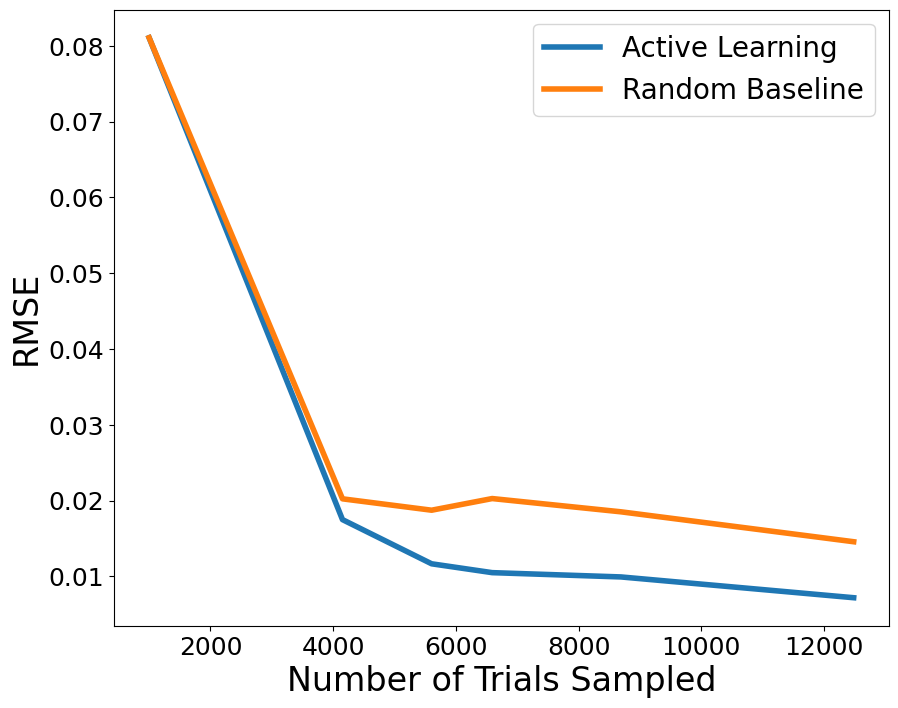

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(num_samples, performances, label='Active Learning', linewidth=4)
plt.plot(num_samples, performances_random, label='Random Baseline', linewidth=4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Trials Sampled', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)

In [ ]:
performances_random